# Solving Ordinary Differential Equation using Neural Networks

Neural networks train based on backpropogated errors signals from the training data. But what if there were some additional constraint on the results of the network that could help the training. When we consider **physical** constraints on the system in order to facilitate learning in the neural network we obtain what is called **physics informed neural networks (PINN)**. 

The particular use case we will consider for PINN's is solving ordinary differential equations. This post is inspired by the the work of [Hubert Baty, Leo Baty](https://arxiv.org/abs/2302.12260).

First Equation to Solve:

$$
\frac{dy}{dt} + 0.1y - \sin (\pi * t/2) = 0 
$$

Solving a differential equation means finding $y(t)$ such that this equation is satisfied. But, solving differential equations is hard and is mostly impossible. So, we often turn to numerical schemes in order to approximate the solution.

## Exact Solution using numerical integration

We will use the Runge-Kutta 4 (RK4) as our numerical integrator to plot the trajectory of the solution in \(t \in [0, 30]\). The RK4 method uses the expressed stated as a function of the first derivative, that is:

$$
\frac{dy}{dt} = \sin (\pi * t/2) - 0.1y
$$

With the initial condition: $y(0) = 1$.

Using this, the method then estimates the change in the value of y for a given step size. Let us see this in action:


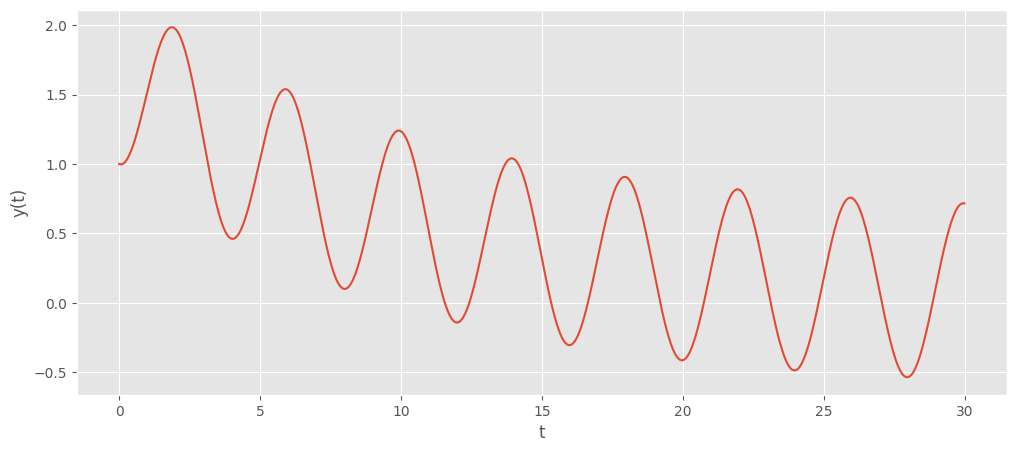

In [18]:
import matplotlib.pyplot as plt
import torch

plt.style.use("ggplot")

def rk4(f, t, y, h):
    k1 = h * f(t, y)
    k2 = h * f(t + h / 2, y + k1 / 2)
    k3 = h * f(t + h / 2, y + k2 / 2)
    k4 = h * f(t + h, y + k3)
    return y + (k1 + 2 * k2 + 2 * k3 + k4) / 6


def solve_ode(f, t0, y0, t_end, h):
    t_values = torch.arange(t0, t_end + h, h)
    y_values = torch.zeros((len(t_values),) + y0.shape, dtype=torch.float32)
    y_values[0] = y0

    for i in range(1, len(t_values)):
        y_values[i] = rk4(f, t_values[i - 1], y_values[i - 1], h)

    return t_values.unsqueeze(1), y_values


def dy_dt(t, y):
    return torch.sin(torch.pi * t / 2) - 1 / 10 * y


# Initial conditions
t0 = 0.0
y0 = torch.tensor([1.0], dtype=torch.float32)
t_end = 30.0
h = 0.01

# Solve the ODE using RK4 method
t_values, y_values = solve_ode(dy_dt, t0, y0, t_end, h)

plt.figure(figsize=(12, 5))
plt.xlabel("t")
plt.ylabel("y(t)")
plt.plot(t_values, y_values)
plt.show()


This is the exact solution to the differential equation. Well not exact since we have used a numerical integrator, but with a simple, non-chaotic system here integrated over a small time scale we can be pretty confident. 

But is to note is that the only way we can find the solution using this method is to step through the integrator. There is no machine where we can plug in a time and it will spit out the y - like what a function does - we can only tell where the particle will be at time t by starting at time 0 and walking through. 

## Use a neural network with no "physical" information

We can use neural networks as a universal approximator in order to try and learn the solution for $y(t)$. We can do this by taking a sample of the solution data set that we obtained using numerical integration, and iteratively learning based on these samples.

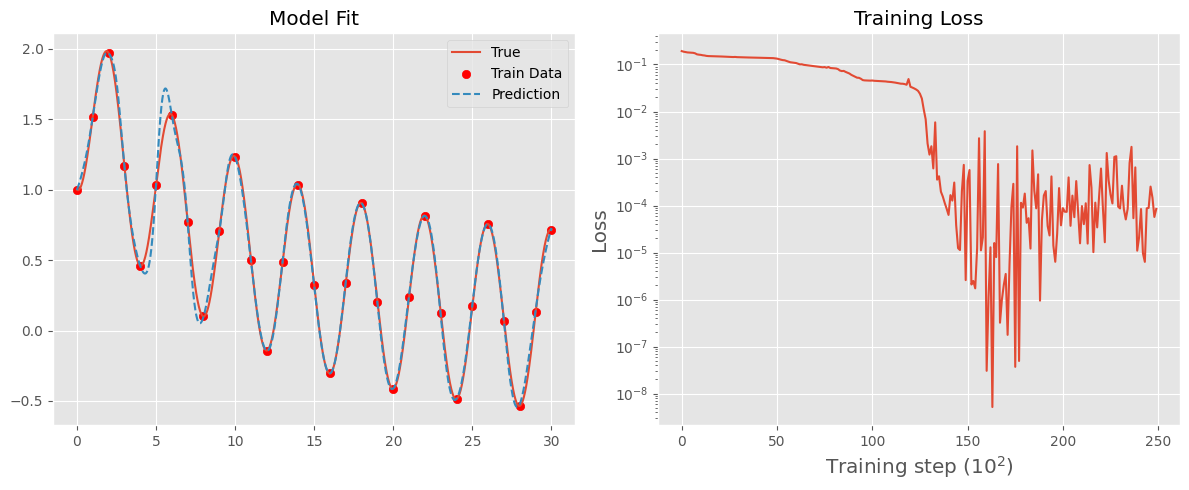

In [20]:
import torch.nn as nn
import torch.optim as optim
torch.manual_seed(123)

class NN(nn.Module):
    def __init__(self, n_input=1, n_output=1, hidden_dim=32):

        super().__init__()

        self.activation = nn.Tanh()
        self.fc1 = nn.Linear(n_input, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, n_output)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.fc3(x)
        return x
    
def plot_result(x, y, x_data, y_data, yh, xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8, 4))
    plt.plot(x, yh, color="tab:red", linewidth=2, alpha=0.8, label="NN prediction")
    plt.plot(
        x,
        y,
        color="blue",
        linewidth=2,
        alpha=0.8,
        linestyle="--",
        label="Exact solution",
    )
    plt.scatter(x_data, y_data, s=60, color="tab:red", alpha=0.4, label="Training data")
    if xp is not None:
        plt.scatter(
            xp,
            -0 * torch.ones_like(xp),
            s=30,
            color="tab:green",
            alpha=0.4,
            label="Collocation points",
        )
    leg = plt.legend(loc=(0.67, 0.62), frameon=False, fontsize="large")
    plt.setp(leg.get_texts(), color="k")
    plt.xlim(-1.25, 31.05)
    plt.ylim(-0.65, 2.25)
    plt.text(2.965, 1.95, "Training step: %i" % (i + 1), fontsize="xx-large", color="k")
    plt.ylabel("y", fontsize="xx-large")
    plt.xlabel("t", fontsize="xx-large")
    plt.axis("on")

def train_nn(lr, epochs, t_train, y_train):
    model = NN()
    optimiser = optim.Adam(model.parameters(), lr=lr)

    loss_history = []

    for i in range(epochs):
        yh = model(t_train)
        loss = torch.mean((yh - y_train) ** 2)

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        if (i + 1) % 100 == 0:
            loss_history.append(loss.detach())

    with torch.no_grad():
        yh = model(t_values).detach()

    return yh, loss_history

lr = 5e-3
epochs = 25000

t_train = t_values[::100]
y_train = y_values[::100]

yh, loss_history = train_nn(lr, epochs, t_train, y_train)
# Create a single figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot the model results on the first subplot
axs[0].plot(t_values, y_values, label="True")
axs[0].scatter(t_train, y_train, color="red", label="Train Data")
axs[0].plot(t_values, yh, label="Prediction", linestyle="--")
axs[0].set_title("Model Fit")
axs[0].legend()

# Plot the loss history on the second subplot
axs[1].plot(loss_history)
axs[1].set_xlabel("Training step ($10^2$)", fontsize="x-large")
axs[1].set_ylabel("Loss", fontsize="x-large")
axs[1].set_yscale("log")
axs[1].set_title("Training Loss")

plt.tight_layout()
plt.show()

As we can see the neural networks settles into a good approximation of the solution of the differential equation just before $15000$ training epochs. Naturally, one can conduct some hyperparameter tuning of the neural network, specifically we will look at different learning rates and their effect on the stability of the solution.

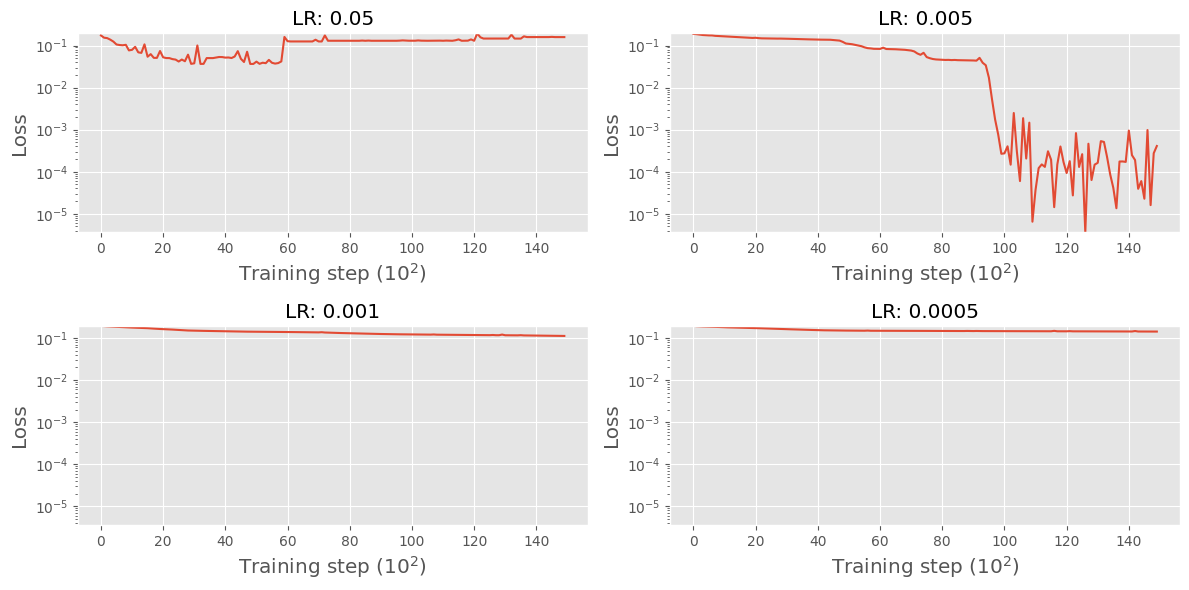

In [21]:
learning_rates = [5e-2, 5e-3, 1e-3, 5e-4]
rows, cols = 2, len(learning_rates) // 2  # Define the grid layout

all_loss_histories = []

for lr in learning_rates:

    yh, loss_history = train_nn(lr, 15000, t_train, y_train)

    all_loss_histories.append(loss_history)

# Find global min and max for standardizing y-axis
min_loss = min(min(loss) for loss in all_loss_histories)
max_loss = max(max(loss) for loss in all_loss_histories)

# Plot results

fig, axs = plt.subplots(rows, cols, figsize=(12, 6))
for idx, (lr, loss_history) in enumerate(zip(learning_rates, all_loss_histories)):
    row, col = divmod(idx, cols)  # Calculate row and column indices
    axs[row, col].plot(loss_history)
    axs[row, col].set_xlabel("Training step ($10^2$)", fontsize="x-large")
    axs[row, col].set_ylabel("Loss", fontsize="x-large")
    axs[row, col].set_yscale("log")
    axs[row, col].set_ylim(min_loss, max_loss)  # Standardize y-axis
    axs[row, col].set_title(f"LR: {lr}")

plt.tight_layout()
plt.show()

Admitedly, this is not very extensive hyperparameter tuning but the point is that the training is very sensitive to the learning rate, as is usual with neural networks and a learning rate too large results in no training whatsoever. 

## Using a physical loss on the neural network

What we have done so far is use data that is generated from the solution to the ODE to train a neural network to approximate whatever function it is that is generating it. And as we have seen it can do that, but there is a slight chicken and egg problem. We need data from the solution to approximate the solution. While actual data from physical processes exists, we want to try and see if we can create a solution to the ODE not using data but by using the constraints of the equation itself.

The ODE is:

$$
\frac{dy}{dt} + 0.1y - \sin (\pi * t/2) = 0 
$$

We can use the constraint of this first order dirivative as regularisation in our training. In other words, we don't want to make a change to the parameter of the neural network that will make $ \mathcal{F} = \frac{dy}{dt} + 0.1y - \sin (\pi * t/2)$ give an answer far away from $0$. That will require us to compute some derivative around out training set. This training set has a special name: Collocation points.

The difference between a collocation point and a training point is that a training point is an instance generated from the function we can trying to approximate while a collocation point is simply the time value where we compute $\mathcal{F}$.

So we will not formulate a loss function given both the training loss and the loss at the collocation points:

$$
L(\theta) = \omega_{data} L_{data}(\theta) + w_{\mathcal{F}} L_{\mathcal{F}}(\theta)
$$

Where $ L_{\mathcal{F}}(\theta) = \| \frac{dy_\theta}{dt} + 0.1y_\theta - \sin (\pi * t/2) \|$


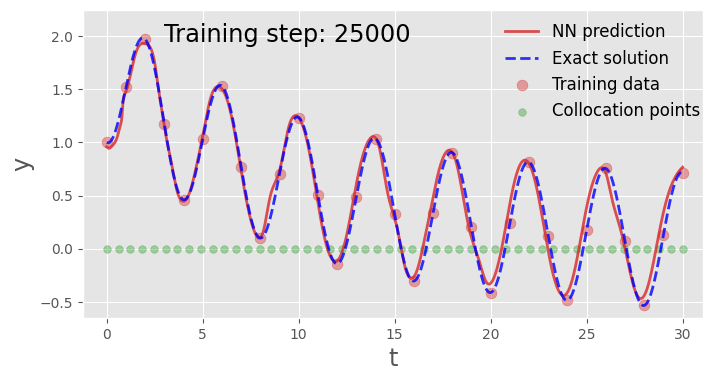

In [28]:
def train_pinn(lr, epochs, t_train, y_train, p_train):
    model = NN()
    optimiser = torch.optim.Adam(model.parameters(), lr=lr)

    loss_history = []
    physics_loss_history = []

    for i in range(epochs):

        # Prediction Loss
        yh = model(t_train)
        pred_loss = torch.mean((yh - y_train) ** 2)

        yhp = model(p_train)
        dx = torch.autograd.grad(yhp, p_train, torch.ones_like(yhp), create_graph=True)[
            0
        ]

        cal_F = dx + 0.1 * yhp - torch.sin(torch.pi * p_train / 2)
        physics_loss = (6e-2) * (torch.mean(cal_F**2))

        loss = pred_loss + physics_loss

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        if (i+1) % 100 == 0:
            loss_history.append(loss.detach())
            physics_loss_history.append(physics_loss.detach())

    with torch.no_grad():
        yh = model(t_values)
        xp = p_train.detach()    
        plot_result(t_values, y_values, t_train, y_train, yh, xp)




p_train = torch.linspace(0, 30, 50).unsqueeze(1).requires_grad_(True)

train_pinn(3e-2, 15000, t_train, y_train, p_train)


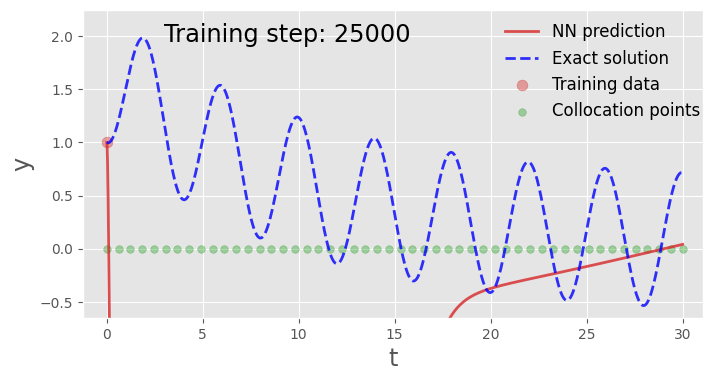

In [40]:

train_pinn(1e-3, 50000, torch.Tensor([[0]]), torch.Tensor([[1]]), p_train)